In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_excel('Data_Set_A.xlsm')

In [3]:
df.shape

(80046, 13)

# Preprocessing

## 1. Standard Scaler

In [4]:
def standardscale(feats, df):
    for feat in feats:
        scaler = StandardScaler()
        scaler.fit(df[feat].values.reshape(-1,1))
        df[feat+"-pre"] = scaler.transform(df[feat].values.reshape(-1,1))
    return df

In [5]:
feats = ["sig3", "sig4", "sig5", "sig6"]
df = standardscale(feats, df)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
df.head(10)

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance,sig3-pre,sig4-pre,sig5-pre,sig6-pre
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0,-0.151670,-0.081007,-0.092444,-0.012204
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1,-0.008290,-0.084120,0.061164,0.154337
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1,-0.158767,-0.074158,-0.148591,0.010002
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1,-0.082105,-0.054856,0.047392,-0.001101
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1,-0.149970,-0.065026,-0.073376,0.143235
5,4631,28629,2,1,0.23,0.44,2147,331,514,39,0.47,0.23,0,-0.115167,-0.085365,-0.019348,0.276468
6,4631,28630,2,1,0.24,0.48,1757,9,478,26,0.45,0.32,0,-0.131740,-0.152193,-0.038417,0.132132
7,4631,28631,2,1,0.27,0.49,6525,370,818,50,0.41,0.48,1,0.070879,-0.077271,0.141676,0.398598
8,4631,28632,2,1,0.32,0.43,5644,2605,1064,67,0.43,0.44,0,0.033441,0.386583,0.271978,0.587344
9,4632,28633,4,1,0.19,0.21,8460,2631,1296,0,0.59,0.60,0,0.153108,0.391979,0.394864,-0.156539


## 2. sig6

In [7]:
df.groupby("sig6").get_group(0)[["sig6","relevance"]].head(10)

,sig6,relevance
9,0,0
10,0,0
11,0,1
12,0,0
13,0,0
14,0,0
15,0,0
16,0,0
17,0,0
18,0,1


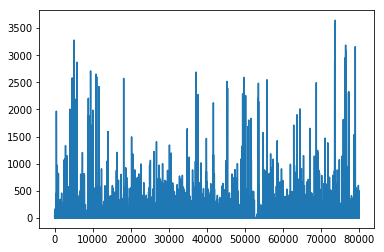

In [10]:
df["sig6"].plot()

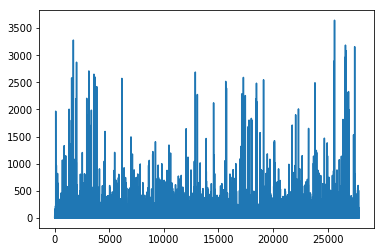

In [11]:
df[df.sig6 != 0]["sig6"].reset_index().pop("sig6").plot()

In [12]:
newdf = df[df.sig6 != 0]["sig6"].reset_index().pop("sig6")
print(len(newdf))
print(len(newdf.loc[newdf>500]))
print(len(newdf[newdf>1000]))
print(len(newdf[newdf>1500]))
print(len(newdf[newdf>2000]))

27881
353
125
66
40


In [13]:
def trans(x):
    if x==0:
        return 0
    elif x<500:
        return 1
    elif x<1000:
        return 2
    elif x<1500:
        return 3
    else: return 4
df["sig6_cls"] = df["sig6"].map(trans)

## 3. Mean Encoding

In [14]:
# Normal Encoding
mean = df.groupby("query_id").relevance.mean()
df["target_query_id_encoded"] = df["query_id"].map(mean)
mean = df.groupby("query_length").relevance.mean()
df["target_query_length_encoded"] = df["query_length"].map(mean)
mean = df.groupby("is_homepage").relevance.mean()
df["target_is_homepage_encoded"] = df["is_homepage"].map(mean)
mean = df.groupby("sig6_cls").relevance.mean()
df["target_sig6_cls_encoded"] = df["sig6_cls"].map(mean)

In [15]:
kf = KFold(n_splits = 5, shuffle = False)
df['target_query_id_encoded_v'] = np.nan

for tr_ind, val_ind in kf.split(df):
    X_tr, X_val = df.iloc[tr_ind], df.iloc[val_ind]
    means = X_val['query_id'].map(X_tr.groupby('query_id').relevance.mean())
    df.loc[val_ind, 'target_query_id_encoded_v'] = means

mean = df["relevance"].mean()
df['target_query_id_encoded_v'].fillna(mean, inplace = True)

In [16]:
kf = KFold(n_splits = 5, shuffle = False)
df['target_query_length_encoded_v'] = np.nan

for tr_ind, val_ind in kf.split(df):
    X_tr, X_val = df.iloc[tr_ind], df.iloc[val_ind]
    means = X_val['query_length'].map(X_tr.groupby('query_length').relevance.mean())
    df.loc[val_ind, 'target_query_length_encoded_v'] = means

mean = df["relevance"].mean()
df['target_query_length_encoded_v'].fillna(mean, inplace = True)

In [17]:
kf = KFold(n_splits = 5, shuffle = False)
df['target_is_homepage_encoded_v'] = np.nan

for tr_ind, val_ind in kf.split(df):
    X_tr, X_val = df.iloc[tr_ind], df.iloc[val_ind]
    means = X_val['is_homepage'].map(X_tr.groupby('is_homepage').relevance.mean())
    df.loc[val_ind, 'target_is_homepage_encoded_v'] = means

mean = df["relevance"].mean()
df['target_is_homepage_encoded_v'].fillna(mean, inplace = True)

In [18]:
kf = KFold(n_splits = 5, shuffle = False)
df['target_sig6_cls_encoded_v'] = np.nan

for tr_ind, val_ind in kf.split(df):
    X_tr, X_val = df.iloc[tr_ind], df.iloc[val_ind]
    means = X_val['sig6_cls'].map(X_tr.groupby('sig6_cls').relevance.mean())
    df.loc[val_ind, 'target_sig6_cls_encoded_v'] = means

mean = df["relevance"].mean()
df['target_sig6_cls_encoded_v'].fillna(mean, inplace = True)

## 4. Agg Feature

In [19]:
for feat in feats:
    mean = df.groupby("query_id")[feat+"-pre"].mean()
    df[feat+"-pre"+"_query_id_encoded"] = df["query_id"].map(mean)
    mean = df.groupby("query_length")[feat+"-pre"].mean()
    df[feat+"-pre"+"_query_length_encoded"] = df["query_length"].map(mean)
    mean = df.groupby("is_homepage")[feat+"-pre"].mean()
    df[feat+"-pre"+"_is_homepage_encoded"] = df["is_homepage"].map(mean)
    mean = df.groupby("sig6_cls")[feat+"-pre"].mean()
    df[feat+"-pre"+"_sig6_cls_encoded"] = df["sig6_cls"].map(mean)

In [20]:
df.columns

Index(['query_id', 'url_id', 'query_length', 'is_homepage', 'sig1', 'sig2',
       'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8', 'relevance', 'sig3-pre',
       'sig4-pre', 'sig5-pre', 'sig6-pre', 'sig6_cls',
       'target_query_id_encoded', 'target_query_length_encoded',
       'target_is_homepage_encoded', 'target_sig6_cls_encoded',
       'target_query_id_encoded_v', 'target_query_length_encoded_v',
       'target_is_homepage_encoded_v', 'target_sig6_cls_encoded_v',
       'sig3-pre_query_id_encoded', 'sig3-pre_query_length_encoded',
       'sig3-pre_is_homepage_encoded', 'sig3-pre_sig6_cls_encoded',
       'sig4-pre_query_id_encoded', 'sig4-pre_query_length_encoded',
       'sig4-pre_is_homepage_encoded', 'sig4-pre_sig6_cls_encoded',
       'sig5-pre_query_id_encoded', 'sig5-pre_query_length_encoded',
       'sig5-pre_is_homepage_encoded', 'sig5-pre_sig6_cls_encoded',
       'sig6-pre_query_id_encoded', 'sig6-pre_query_length_encoded',
       'sig6-pre_is_homepage_encoded', 'sig

# Training

In [21]:
data = df[["sig1",
            "sig2",
            "sig7",
            "sig8",
            "sig3-pre",
            "sig4-pre",
            "sig5-pre",
            "sig6-pre",
            "target_query_id_encoded",
            "target_query_length_encoded",
            "target_is_homepage_encoded",
            "target_query_id_encoded_v",
            "target_query_length_encoded_v",
            "target_is_homepage_encoded_v",
            #"target_sig6_cls_encoded_v"
           'sig3-pre_query_id_encoded', 'sig4-pre_query_id_encoded',
           'sig5-pre_query_id_encoded', 'sig6-pre_query_id_encoded',
           'sig3-pre_query_length_encoded', 'sig3-pre_is_homepage_encoded',
           'sig3-pre_sig6_cls_encoded', 'sig4-pre_query_length_encoded',
           'sig4-pre_is_homepage_encoded', 'sig4-pre_sig6_cls_encoded',
           'sig5-pre_query_length_encoded', 'sig5-pre_is_homepage_encoded',
           'sig5-pre_sig6_cls_encoded', 'sig6-pre_query_length_encoded',
           'sig6-pre_is_homepage_encoded', 'sig6-pre_sig6_cls_encoded'
            ]]

In [26]:
for col in pop_cols:
    data.pop(col)

In [27]:
np.random.seed(0)
length = len(data)
perm = np.random.permutation(length)
train_x = data.loc[perm[:int(0.8*length)]]
val_x = data.loc[perm[int(0.8*length):int(0.1*length)]]
test_x = data.loc[perm[int(0.1*length):]]
train_y = df.loc[perm[:int(0.8*length)]].relevance
val_y = df.loc[perm[int(0.8*length):int(0.1*length)]].relevance
test_y = df.loc[perm[int(0.1*length):]].relevance

In [28]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=200,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(train_x, train_y)
train_pred_y = rf.predict(train_x)
test_pred_y = rf.predict(test_x)

In [115]:
# original
print("Training Accuracy: %.4f" % accuracy_score(train_y, train_pred_y))
print("Testing Accuracy: %.4f" % accuracy_score(test_y, test_pred_y))
print("Out-of-bag Accuracy %.4f" % rf.oob_score_)

Training Accuracy: 0.9352
Testing Accuracy: 0.8950
Out-of-bag Accuracy 0.7515


In [76]:
# with sig6_cls
print("Training Accuracy: %.4f" % accuracy_score(train_y, train_pred_y))
print("Testing Accuracy: %.4f" % accuracy_score(test_y, test_pred_y))
print("Out-of-bag Accuracy %.4f" % rf.oob_score_)

Training Accuracy: 0.9334
Testing Accuracy: 0.8926
Out-of-bag Accuracy 0.7518


In [111]:
# with many features
print("Training Accuracy: %.4f" % accuracy_score(train_y, train_pred_y))
print("Testing Accuracy: %.4f" % accuracy_score(test_y, test_pred_y))
print("Out-of-bag Accuracy %.4f" % rf.oob_score_)

Training Accuracy: 0.9443
Testing Accuracy: 0.9025
Out-of-bag Accuracy 0.7591


In [124]:
# with many features trimmed
print("Training Accuracy: %.4f" % accuracy_score(train_y, train_pred_y))
print("Testing Accuracy: %.4f" % accuracy_score(test_y, test_pred_y))
print("Out-of-bag Accuracy %.4f" % rf.oob_score_)

Training Accuracy: 0.9493
Testing Accuracy: 0.9062
Out-of-bag Accuracy 0.7597


In [29]:
print("Importance scores:", rf.feature_importances_)
print("Most Important features: ",data.columns[np.argmax(rf.feature_importances_)])
pop_cols = data.columns[np.argsort(rf.feature_importances_)[:10]]

Importance scores: [0.05838444 0.10062499 0.04104686 0.04615337 0.0510821  0.04483481
 0.04531922 0.03606319 0.30022962 0.02539989 0.02028711 0.04657706
 0.04493323 0.04774955 0.04325797 0.00708117 0.01119956 0.00929983
 0.00917715 0.01129887]
Most Important features:  target_query_id_encoded


# Ensemble

In [131]:
lr = LogisticRegression()
lr.fit(train_x, train_y)
pred_lr_train = lr.predict(train_x)
pred_lr_test = lr.predict(test_x)

In [132]:
print("Training Accuracy: %.4f" % accuracy_score(train_y, pred_lr_train))
print("Testing Accuracy: %.4f" % accuracy_score(test_y, pred_lr_test))

Training Accuracy: 0.7549
Testing Accuracy: 0.7542


In [34]:
import xgboost as xgb
dtrain = xgb.DMatrix(train_x, label=train_y)
dval = xgb.DMatrix(val_x, label=val_y)

param = {'bst:max_depth':5, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic', 'nthread':4 }
plst = param.items()

evallist  = [(dval,'eval'), (dtrain,'train')]
num_round = 2000
bst = xgb.train(plst, dtrain, num_round, evallist)

In [42]:
dtest = xgb.DMatrix(test_x, label=test_y)
preds = bst.predict(dtest, ntree_limit=bst.best_ntree_limit, output_margin=True)
labels = dtest.get_label()

In [43]:
print('accuray=%.f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) == labels[i]) / float(len(preds))))

accuray=1
